## **사용자 기반 네이버 메일 알림 시스템**

[1. 네이버 메일 자동 로그인](#네이버-메일-자동-로그인)

[ 2. 사용자의 메일 데이터를 수집](#사용자의-메일-데이터를-수집) <br/>
    (읽음 여부, 발신인, 메일 제목, 발신 날짜)  <br/>
    메일 5000개 당 약 한 시간 소요
    
    
[ 3. 데이터 전처리](#데이터-전처리) <br/>
    읽음 여부는 읽은 메일을 1, 읽지 않은 경우 0 <br/>
    발신인과 메일 제목은 명사 추출 후 이를 활용하여 TF-IDF 벡터화 진행 <br/>
    발신인 메일 제목의 길이를 활용하여 피쳐 사용 <br/>
    발신 날짜는 해당 년도, 월, 시각 이용

[ 4. imbalanced_data 확인 여부 후, 데이터 resampling ](#imbalanced_data)

[ 5. train, validation 데이터 분할](#train,-validation-데이터-분할)

[ 6. Features selection](#Features-selection)

[ 7. Modeling ( LGBM Classifier, Logistic Regression 사용 )](#Modeling)

[ 8. Scoring](#Scoring)

[ 9. 사용자 메일 내용 워드 클라우딩](#사용자-메일-내용-워드-클라우딩)

In [87]:
def print_term_topics(term, dictionary, model):
    word_id = dictionary.token2id[term]   #단어의 아이디 구함
    print(model.get_term_topics(word_id))  
    
# 문서에 대한 토픽가중치를 반복하면서 전체 문서에 대해서 표시
def print_doc_topics(model, corpus): 
    
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        print("Doc num: {}".format(doc_num))

        for topic_id, prob in topic_probs:
            print("\t{}\t{}".format(topic_id, prob))
        
        if doc_num == 2:  # 시간 관계상 2번 문서까지만 출력, "0번문서, 1번문서, 2번문서"에 대해서만 해당문서의 토픽가중치를 표시                                     
            break

        print("\n")  

# ★ 모델링 후 각 토픽별로 중요한 단어들을 표시
def print_topic_words(model):
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))
        print("\n")

In [8]:
# 사용 모듈

from gensim import corpora #gensim 에서 제공하는 패키지
from gensim import models
from gensim.models import CoherenceModel
from collections import Counter #카운터 사용
import pyLDAvis.gensim_models # LDA시각화

import os
import warnings
import time
from tqdm import tqdm
import gc
import shap

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import matplotlib as mpl
from matplotlib import font_manager
from PIL import Image
import matplotlib.font_manager as fm 
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='Malgun Gothic')  

import pandas as pd
import numpy as np

from selenium import webdriver
from bs4 import BeautifulSoup
import pyperclip

import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from selenium.webdriver.common.keys import Keys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt; okt=Okt()
from collections import Counter
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from bayes_opt import BayesianOptimization

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from imblearn.ensemble import BalancedRandomForestClassifier

#### 네이버 메일 자동 로그인
- 자신의 아이디와 비밀번호를 해당 칸에 입력해야 로그인 가능

In [113]:
# 드라이버 설정
driver = webdriver.Chrome('C:\chromedriver.exe')
time.sleep(0.5)
driver.implicitly_wait(3)

# 페이지 설정
driver.get('https://mail.naver.com')

# 네이버 자동 로그인
driver.find_element_by_name('id').click()

# 자동 로그인 우회 방식
pyperclip.copy('minsung0321') # 아이디
driver.find_element_by_name('id').send_keys(Keys.CONTROL, 'v')
driver.find_element_by_name('pw').click() # 패스워드
pyperclip.copy('alstjdsjaqj0*')
driver.find_element_by_name('pw').send_keys(Keys.CONTROL, 'v')

# 로그인 클릭
driver.find_element_by_id('log.login').click()

html = driver.page_source 
soup = BeautifulSoup(html, 'html.parser')

# 팝업창 닫기
#driver.find_element_by_xpath("//*[@id='smartFolderLayer']/div/div/button").send_keys(Keys.ENTER)

#### 사용자의 메일 데이터를 수집
- 메일함 데이터 수집 (동적 크롤링) 5000개당 약 한시간 소요

In [114]:
# 페이지 넘기기
k=1
data=[[] for _ in range(4)]
contents_list=[]
for _ in tqdm(range(1)):  # 1011 페이지까지 있음.  # 2시간 소요 
    # 페이지가 넘어갈 때마다 크롤링 재설정
    sendlist = driver.find_elements_by_css_selector('div.name')
    time.sleep(1)
    maillist = driver.find_elements_by_css_selector('strong.mail_title')
    time.sleep(1)
    read_jugements = driver.find_elements_by_css_selector('li.read > a')
    time.sleep(1)
    dates = driver.find_elements_by_css_selector('li.iDate')
    time.sleep(1)
    #driver.find_elements_by_css_selector('div.subject').click()
    #time.sleep(1)
    # 데이터 수집     발신인 , 제목
    

    for mail in zip(sendlist, maillist, dates, read_jugements):
        for j in range(3):
            data[j].append(mail[j].text)
        data[3].append(mail[3].get_attribute("title"))
    time.sleep(1)
    
    for i in range(len(sendlist)):
        driver.find_elements_by_css_selector('strong.mail_title')[i].click()
        time.sleep(0.5)
        contents = driver.find_elements_by_id('readFrame')[0]
        time.sleep(0.5)
        contents_list.append(contents.text)
        driver.execute_script("window.history.go(-1)")
        time.sleep(0.5)
        
        
    # 넘길 페이지 선정         개인의 마지막 페이지 설정 필요 *
    if k==10:   # 10페이지에 도달하면 다음 페이지로 넘기기
        page_bar = list(driver.find_elements_by_css_selector("div.paginate > *"))[-2]
        k=1    # 페이지가 넘어가면 자동으로 1페이지부터 시작.
    else:
        page_bar = list(driver.find_elements_by_css_selector("span.paging_numbers > *"))[k]
        k+=1
    # 페이지 넘기기
    time.sleep(0.5)
    page_bar.send_keys(Keys.ENTER)
    time.sleep(0.5)

# 데이터 프레임
df=pd.DataFrame({"FROM":data[0],"TEXT":data[1],"DATE":data[2],"CONTENTS": contents_list, "JUDGE":data[3]})
df.to_csv("naver_mail_1",index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:44<00:00, 44.55s/it]


In [222]:
# 데이터 불러오기
df=pd.read_csv("naver_mail_11")
df

,FROM,TEXT,DATE,CONTENTS,JUDGE
0,네이버 MYBOX,[네이버 MYBOX] 서비스 이용 약관 변경 안내 (휴면 처리 정책 변경),06-17 12:03,네이버 MYBOX 서비스 이용 약관 개정 안내\n안녕하세요. 네이버 MYBOX 서비...,읽은 메일
1,서울시청,3년 만에 풍덩~ 한강 수영장·물놀이장 24일 개장,06-17 05:35,제 4716 호 · 2022년 6월 17일 금요일\n· 얼마나 기다렸다고! 한강 수...,읽은 메일
2,고유미,[학생생활상담센터]또래상담자 모집,06-16 09:11,학생생활상담센터에서는 2022년 2학기 재학생들을 대상으로 1:1 또래상담을 진행할...,읽은 메일
3,서울시청,서울시 공무원 365명 뽑는다...시험일정은?,06-16 05:35,제 4715 호 · 2022년 6월 16일 목요일\n· 두구두구~ 제3회 서울시 공...,읽은 메일
4,미래인재연구원,[국민대학교 경력개발지원단] 3학년 상시진로지도프로그램 14주차,06-15 13:08,상시진로지도프로그램 메일 관련 문의 : 070-5001-6046\n팩스 : 070-...,읽은 메일
...,...,...,...,...,...
2581,"전대모 (대학생,레포트,토익,족보,스펙,공모전,자격증,편입학)","(광고)[전대모] 2021 하반기 HOT 채용♨ 코레일, 인천국제공항공사 합격하려면...",2021-08-12 11:08,"전체 멤버 메일\n(광고)[전대모] 2021 하반기 HOT 채용♨ 코레일, 인천국제...",읽지않은 메일
2582,알라딘[경영/외국어],"(광고) 박세익의 행복한 투자 <투자의 본질>, 능력보다 중요한 <인성의 힘>, 청...",2021-08-12 08:53,경제경영/자기계발/외국어/컴퓨터 2021.08.12\nMD가 주목한 책\n감으로만 ...,읽지않은 메일
2583,Stocktwits Daily Rip,Delta Doom,2021-08-12 07:59,The U.S wanted COVID out the door by the Summe...,읽지않은 메일
2584,서울시청,"수소차로 바꿔볼까? 보조금 3,350만원 17일부터 접수",2021-08-12 07:28,2021년 8월 12일 목요일\n발행 호수 4509호 내 손안에 서울 뉴스레터\n뉴...,읽지않은 메일


#### 데이터 전처리

In [223]:
# 날짜 피쳐 전처리
df["DATE"][:874]=df["DATE"][:874].apply(lambda x: "2022-"+x) # 2022년은 다르게 표시 됨.
df["DATE"]=pd.to_datetime(df["DATE"])
df["YEAR"]=df["DATE"].dt.year     # 년도, 월, 시각으로 처리
df["MONTH"]=df["DATE"].dt.month
df["HOUR"]=df["DATE"].dt.hour
del df["DATE"]

In [224]:
def label(x):    # 읽은 메일이라면 1, 읽지 않았다면 0
    if x=="읽은 메일":
        return 1
    else:
        return 0
df["JUDGE"]=df["JUDGE"].apply(label)

- 메일 읽음 여부 (정답 라벨) imbalanced data

In [225]:
df["JUDGE"].value_counts()

0    2471
1     115
Name: JUDGE, dtype: int64

In [226]:
# 메일 내용 전처리
df['CONTENTS'] = df['CONTENTS'].fillna(df['TEXT'])
# 메일 내용이 없고, 이미지만 있을 경우 결측값이 나와 메일 제목으로 내용 대체
df["CONTENTS"]=df["CONTENTS"].apply(lambda x: x.replace("\n"," "))

In [227]:
df["from_len"]=df["FROM"].apply(lambda x : len(x)) # 수신인의 길이 피쳐로 활용
df["text_len"]=df["TEXT"].apply(lambda x : len(x)) # 제목의 길이 피쳐로 활용
df["content_len"]=df["CONTENTS"].apply(lambda x : len(x)) # 메일 내용의 길이 피쳐로 홯용

In [228]:
df.head()

,FROM,TEXT,CONTENTS,JUDGE,YEAR,MONTH,HOUR,from_len,text_len,content_len
0,네이버 MYBOX,[네이버 MYBOX] 서비스 이용 약관 변경 안내 (휴면 처리 정책 변경),네이버 MYBOX 서비스 이용 약관 개정 안내 안녕하세요. 네이버 MYBOX 서비스...,1,2022,6,12,9,41,994
1,서울시청,3년 만에 풍덩~ 한강 수영장·물놀이장 24일 개장,제 4716 호 · 2022년 6월 17일 금요일 · 얼마나 기다렸다고! 한강 수영...,1,2022,6,5,4,28,1300
2,고유미,[학생생활상담센터]또래상담자 모집,학생생활상담센터에서는 2022년 2학기 재학생들을 대상으로 1:1 또래상담을 진행할...,1,2022,6,9,3,18,229
3,서울시청,서울시 공무원 365명 뽑는다...시험일정은?,제 4715 호 · 2022년 6월 16일 목요일 · 두구두구~ 제3회 서울시 공무...,1,2022,6,5,4,25,1267
4,미래인재연구원,[국민대학교 경력개발지원단] 3학년 상시진로지도프로그램 14주차,상시진로지도프로그램 메일 관련 문의 : 070-5001-6046 팩스 : 070-8...,1,2022,6,13,7,35,300


In [229]:
# 수신인 정보 자체로만은 텍스트 분석하기에 텍스트가 부족하다고 판단하여, 제목 텍스트와 결합
df["TEXT"] = df["FROM"]+" " + df["TEXT"]

In [230]:
#토큰화
def tokenize_kor(sent):
    return [word for word in okt.nouns(sent) if len(word) >= 2]

def tokenize_eng(sent):
    is_noun = lambda pos : pos[:2]=="NN"
    tokenized = nltk.word_tokenize(sent)
    return [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
    
tokenized_doc = df['CONTENTS'].apply(lambda x: tokenize_eng(x) if x[0].isalpha() else  tokenize_kor(x)) # 토큰화
tokenized_doc_1 = df['TEXT'].apply(lambda x: tokenize_eng(x) if x[0].isalpha() else  tokenize_kor(x)) # 토큰화

- 한글과 영어를 구분하여 각각 명사 토큰화

In [231]:
print(tokenized_doc[0])

['네이버', 'MYBOX', '서비스', '이용', '약관', '개정', '안내', '안녕하세요', '네이버', 'MYBOX', '서비스팀입니다', '네이버', 'MYBOX', '서비스를', '이용해', '주시는', '회원님께', '진심으로', '감사드립니다', '자로', '네이버', 'MYBOX', '서비스', '이용', '약관을', '개정함에', '따라', '회원님께', '개정', '내용과', '일정을', '알려드립니다', '아래와', '같습니다', 'MYBOX에', '저장된', '데이터를', '더', '안전하게', '보관하기', '위해', '휴면', '정책', '적용', '대상의', '기준을', '완화하였습니다', '계약의', '해지', '등', '제3항', '변경', '전', '이상', '네이버', 'MYBOX에', '로그인하여', '방문한', '기록이', '없는', '아이디', '변경', '후', '이상', '네이버', 'MYBOX에', '로그인하여', '방문한', '기록이', '없는', '◦', '사전', '공지일', '◦', '개정', '약관', '적용일', '◦', '단', '개정', '약관의', '효력이', '발생하기', '전', '이전', 'MYBOX에', '이상', '로그인하지', '않은', '회원은', '개정', '전', '약관에', '따라', '휴면', '처리됩니다', '네이버', 'MYBOX', '서비스', '이용', '약관에', '동의하지', '않으실', '경우', '네이버', '고객센터를', '통해', '탈퇴', '신청', '또는', '이의를', '제기할', '수', '있습니다', '별도의', '이의', '제기를', '하지', '않으시면', '네이버', 'MYBOX', '서비스', '이용', '약관', '개정에', '동의한', '것으로', '보아', '시행일로부터', '개정된', '네이버', '서비스', '이용', '약관이', '적용됩니다', '문의사항은', '고객센터로', '연락주시면', '신속하게', '안내드리겠습니다', '네

In [232]:
# 역토큰화 (토큰화 작업을 역으로 되돌림)
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['CONTENTS'] = detokenized_doc

In [233]:
df['CONTENTS'][0]

'네이버 MYBOX 서비스 이용 약관 개정 안내 안녕하세요 네이버 MYBOX 서비스팀입니다 네이버 MYBOX 서비스를 이용해 주시는 회원님께 진심으로 감사드립니다 자로 네이버 MYBOX 서비스 이용 약관을 개정함에 따라 회원님께 개정 내용과 일정을 알려드립니다 아래와 같습니다 MYBOX에 저장된 데이터를 더 안전하게 보관하기 위해 휴면 정책 적용 대상의 기준을 완화하였습니다 계약의 해지 등 제3항 변경 전 이상 네이버 MYBOX에 로그인하여 방문한 기록이 없는 아이디 변경 후 이상 네이버 MYBOX에 로그인하여 방문한 기록이 없는 ◦ 사전 공지일 ◦ 개정 약관 적용일 ◦ 단 개정 약관의 효력이 발생하기 전 이전 MYBOX에 이상 로그인하지 않은 회원은 개정 전 약관에 따라 휴면 처리됩니다 네이버 MYBOX 서비스 이용 약관에 동의하지 않으실 경우 네이버 고객센터를 통해 탈퇴 신청 또는 이의를 제기할 수 있습니다 별도의 이의 제기를 하지 않으시면 네이버 MYBOX 서비스 이용 약관 개정에 동의한 것으로 보아 시행일로부터 개정된 네이버 서비스 이용 약관이 적용됩니다 문의사항은 고객센터로 연락주시면 신속하게 안내드리겠습니다 네이버 MYBOX는 앞으로도 더욱 신뢰받는 서비스로 보답할 수 있도록 최선을 다하겠습니다 감사합니다 MYBOX 서비스팀 드림 발신전용 입니다 네이버 MYBOX 고객센터에서 확인해주세요 이메일 ccnaver @ naver.com MYBOX 이용약관 © NAVER Corp. 상호 대표이사 주소 성남시 분당구 MYBOX 유료상품 이용약관 MYBOX 환불정책 © NAVER Cloud Corp'

In [234]:
# 한 글자 토큰들은 삭제 진행    -  의미없는 단어들이 포함된 경우가 많음.
def lst_check(x):
    for num, i in enumerate(x):
        if len(i)==1:
            x.pop(num)
    return x

tokenized_doc=tokenized_doc.apply(lambda x: lst_check(x))
tokenized_doc_1=tokenized_doc_1.apply(lambda x: lst_check(x))

In [235]:
# documents을 받아서 문서 단어 행렬 만듬
def build_doc_term_mat(documents): 
    
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary

In [236]:
corpus, dictionary = build_doc_term_mat(tokenized_doc)
corpus_1, dictionary_1 = build_doc_term_mat(tokenized_doc_1)

In [237]:
print(dictionary.token2id)

{'Cloud': 0, 'Corp': 1, 'Corp.': 2, 'MYBOX': 3, 'MYBOX는': 4, 'MYBOX에': 5, 'NAVER': 6, 'ccnaver': 7, 'naver.com': 8, '감사드립니다': 9, '감사합니다': 10, '같습니다': 11, '개정': 12, '개정된': 13, '개정에': 14, '개정함에': 15, '것으로': 16, '경우': 17, '계약의': 18, '고객센터로': 19, '고객센터를': 20, '고객센터에서': 21, '공지일': 22, '기록이': 23, '기준을': 24, '내용과': 25, '네이버': 26, '다하겠습니다': 27, '단': 28, '대상의': 29, '대표이사': 30, '더욱': 31, '데이터를': 32, '동의하지': 33, '동의한': 34, '드림': 35, '따라': 36, '또는': 37, '로그인하여': 38, '로그인하지': 39, '문의사항은': 40, '발생하기': 41, '발신전용': 42, '방문한': 43, '변경': 44, '별도의': 45, '보관하기': 46, '보답할': 47, '보아': 48, '분당구': 49, '사전': 50, '상호': 51, '서비스': 52, '서비스로': 53, '서비스를': 54, '서비스팀': 55, '서비스팀입니다': 56, '성남시': 57, '시행일로부터': 58, '신뢰받는': 59, '신속하게': 60, '신청': 61, '아래와': 62, '아이디': 63, '안내': 64, '안내드리겠습니다': 65, '안녕하세요': 66, '안전하게': 67, '않으시면': 68, '않으실': 69, '않은': 70, '알려드립니다': 71, '앞으로도': 72, '약관': 73, '약관에': 74, '약관을': 75, '약관의': 76, '약관이': 77, '없는': 78, '연락주시면': 79, '완화하였습니다': 80, '위해': 81, '유료상품': 82, '이메일': 83, '이상': 84, '이용': 8

In [238]:
MA_KEY = "body_ma" #내용에 대한 부분은 bady_ma 키에 적혀져 있음
NUM_TOPICS = 7     #토픽의 개수
NUM_TOPIC_WORDS = 10   #하나의 토픽에 포함되는 단어수

In [239]:
lda_model =models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,id2word=dictionary, alpha=1)
lda_model_1 =models.ldamodel.LdaModel(corpus_1, num_topics=NUM_TOPICS,id2word=dictionary_1, alpha=1)
# corpus와 dictionary를 파라미터로 넣고, 하이퍼파라미터 알파, 베타가 있는데 베타는 기본값, 알파는 1을 넣어본다.
# 토픽의 개수는 NUM_TOPICS=7로 지정
# 토픽의 종류를 실험적으로 ( 5, 7, 10, 12, 15 를 실험해보았으나 7로 하였을 때 가장 구분이 잘 된 모습을 보임)

In [240]:
print_term_topics('쿠폰', dictionary, lda_model)  # 특정 용어의 토픽별 가중치 출력
# 광고라는 단어는 0번 토픽에서는 0.041834293의 가중치를 갖는다.
# 거의 모든 토픽의 높은 가중치를 가지며 특히, 2번 토픽에서 0.13214238로 가장 큰 가중치를 가진다.
# 이에 따라 2번 토픽은 '광고' 토픽으로 분류가 된다.

[(3, 0.010671361), (5, 0.04441459)]


In [241]:
# ★ 전체 토픽별 주요 단어 출력 
print_doc_topics(lda_model, corpus)                      

Doc num: 0
	1	0.8503977060317993
	3	0.10549916326999664
	6	0.010694618336856365


Doc num: 1
	0	0.04009156674146652
	1	0.3810946047306061
	3	0.38756710290908813
	4	0.0640513151884079
	6	0.10954093188047409


Doc num: 2
	0	0.11319241672754288
	1	0.45945778489112854
	2	0.04876817762851715
	3	0.09875275194644928
	4	0.11245690286159515
	5	0.06881273537874222
	6	0.09855921566486359


In [242]:
# ★ 전체 토픽별 주요 단어 출력 
print_doc_topics(lda_model_1, corpus)                      

Doc num: 0
	0	0.04008663818240166
	1	0.24822598695755005
	2	0.030747292563319206
	3	0.33209705352783203
	4	0.05739409849047661
	5	0.038768358528614044
	6	0.25268056988716125


Doc num: 1
	0	0.42383047938346863
	1	0.1488899290561676
	2	0.03454582765698433
	3	0.10161792486906052
	4	0.03964610770344734
	5	0.05631006509065628
	6	0.19515961408615112


Doc num: 2
	0	0.16647839546203613
	1	0.10585033148527145
	2	0.10963086038827896
	3	0.10716842859983444
	4	0.1847173124551773
	5	0.10501541197299957
	6	0.22113926708698273


In [243]:
topic_list=[]        # 문서 별 토픽 구분
topic_list_1=[]   
def what_doc_topics(model, corpus, lst):
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        topic_probs=sorted(topic_probs, key= lambda x: x[1])[-1][0]
        lst.append(topic_probs)
what_doc_topics(lda_model, corpus, topic_list)   
print(topic_list[:5])

what_doc_topics(lda_model, corpus_1, topic_list_1)   

[1, 3, 1, 1, 1]


In [244]:
# 결과 0.nmh/topic_vis.html          # 토픽 시각화
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)

pyLDAvis.save_html(vis, "RESULT_4.html")

In [245]:
# 토픽 분류 데이터 프레임에 추가
df["text_TOPIC"] = topic_list_1
df["content_TOPIC"] = topic_list

In [246]:
del df["FROM"], df["TEXT"], df["CONTENTS"]

In [247]:
df   # 최종 데이터 프레임 완성
# 기존에는 tf-idf를 통해 피쳐로 사용했지만, 너무 많은 피쳐가 생성되어 진행 x

,JUDGE,YEAR,MONTH,HOUR,from_len,text_len,content_len,text_TOPIC,content_TOPIC
0,1,2022,6,12,9,41,994,6,1
1,1,2022,6,5,4,28,1300,1,3
2,1,2022,6,9,3,18,229,1,1
3,1,2022,6,5,4,25,1267,1,1
4,1,2022,6,13,7,35,300,3,1
...,...,...,...,...,...,...,...,...,...
2581,0,2021,8,11,34,56,989,4,6
2582,0,2021,8,8,11,73,1776,1,4
2583,0,2021,8,7,20,10,9371,6,2
2584,0,2021,8,7,4,31,1328,3,1


In [248]:
# 정답 레이블 분리
y_train = df["JUDGE"]
del df["JUDGE"]

#### imbalanced_data

In [249]:
# imbalanced data로 인해 전부 0으로 예측하기만 해도 손쉽게 정확도가 90프로 이상
# -> class 1 (읽을 것으로 예측되는 데이터) 를 잘 맞출 수 있도록 데이터 리샘플링 필요
# undersampling 기법, oversampling 기법 사용 후 class1 에 대한 recall 이 더 높은 경우 채택
def imbalanced_process(model,x,y,z=0):
    X_train, X_dev, y_train, y_dev = train_test_split(x,y, test_size=0.3, random_state=77) 
    # 훈련 및 검증 데이터 분리
    if z!=0:
        X, y = z.fit_resample(X_train, y_train)
    else: X,y=x,y
    model.fit(X, y)
    y_pred=model.predict(X_train)
    y1_pred=model.predict(X_dev)
    print("TRAIN"); print(classification_report(y_train, y_pred, target_names=['class 0', 'class 1']))
    print("VALID"); print(classification_report(y_dev, y1_pred, target_names=['class 0', 'class 1']))
    
    
model=LGBMClassifier(random_state=0, n_jobs=-1)

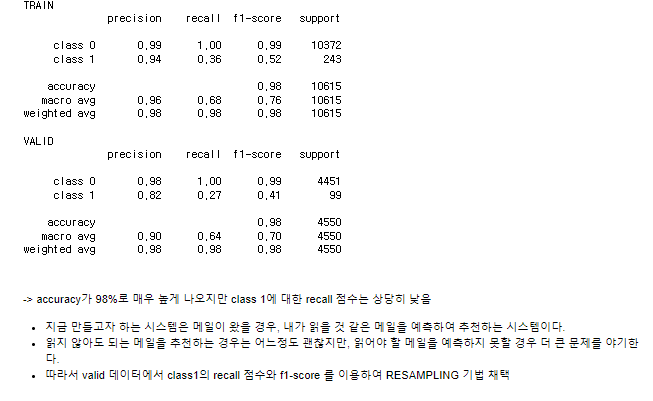

In [250]:
# 데이터 리샘플링 이전
imbalanced_process(model,df,y_train)

TRAIN
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      1735
     class 1       0.99      0.95      0.97        75

    accuracy                           1.00      1810
   macro avg       0.99      0.97      0.98      1810
weighted avg       1.00      1.00      1.00      1810

VALID
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       736
     class 1       1.00      0.97      0.99        40

    accuracy                           1.00       776
   macro avg       1.00      0.99      0.99       776
weighted avg       1.00      1.00      1.00       776



-> accuracy가 98%로 매우 높게 나오지만 class 1에 대한 recall 점수는 상당히 낮음

- 지금 만들고자 하는 시스템은 메일이 왔을 경우, 내가 읽을 것 같은 메일을 예측하여 추천하는 시스템이다.

- 읽지 않아도 되는 메일을 추천하는 경우는 어느정도 괜찮지만, 읽어야 할 메일을 예측하지 못할 경우 더 큰 문제를 야기한다.

- 따라서 valid 데이터에서 class1의 recall 점수와 f1-score 를 이용하여 RESAMPLING 기법 채택

In [251]:
print("데이터 언더샘플링 RandomUnderSampler")
imbalanced_process(model,df,y_train,RandomUnderSampler(random_state=0))

print("데이터 언더샘플링 NearMiss")
imbalanced_process(model,df,y_train,NearMiss(version=1,n_jobs=-1))

print("데이터 오버샘플링 RandomOverSampler")
imbalanced_process(model,df,y_train,RandomOverSampler(random_state=0))

print("데이터 오버샘플링 SMOTE")
imbalanced_process(model,df,y_train,SMOTE(random_state=0,k_neighbors=5,n_jobs=-1))

print("데이터 오버샘플링 BorderlineSMOTE")
imbalanced_process(model,df,y_train,BorderlineSMOTE(kind = 'borderline-1',random_state=0,n_jobs=-1))

데이터 언더샘플링 RandomUnderSampler
TRAIN
              precision    recall  f1-score   support

     class 0       1.00      0.84      0.91      1735
     class 1       0.21      0.99      0.34        75

    accuracy                           0.84      1810
   macro avg       0.60      0.91      0.63      1810
weighted avg       0.97      0.84      0.89      1810

VALID
              precision    recall  f1-score   support

     class 0       0.99      0.82      0.90       736
     class 1       0.19      0.78      0.31        40

    accuracy                           0.82       776
   macro avg       0.59      0.80      0.60       776
weighted avg       0.94      0.82      0.87       776

데이터 언더샘플링 NearMiss
TRAIN
              precision    recall  f1-score   support

     class 0       1.00      0.49      0.66      1735
     class 1       0.08      0.96      0.14        75

    accuracy                           0.51      1810
   macro avg       0.54      0.72      0.40      1810
weighted

- 오버샘플링 RandomOverSampler 채택

#### train, validation 데이터 분할

In [252]:
# 검증 데이터 분리
X_train, X_dev, y_train, y_dev = train_test_split(df, y_train, test_size=0.3, random_state=77) 
left_df = len(X_train)
train, label = X_train, y_train

In [253]:
# 한 쪽 클래스가 20프로 이하일 경우 데이터 샘플링
if y_train.value_counts()[0]/len(y_train) >=0.8 or y_train.value_counts()[0]/len(y_train) <= 0.2: 
    X_train, y_train = RandomOverSampler(random_state=0).fit_resample(X_train, y_train)
    print(f' 데이터 resampling 전 {left_df} 개 \n 데이터 resampling 후 {len(X_train)} 개')
else:
    print("resmapling 필요 없음.")

 데이터 resampling 전 1810 개 
 데이터 resampling 후 3470 개


##### Features selection

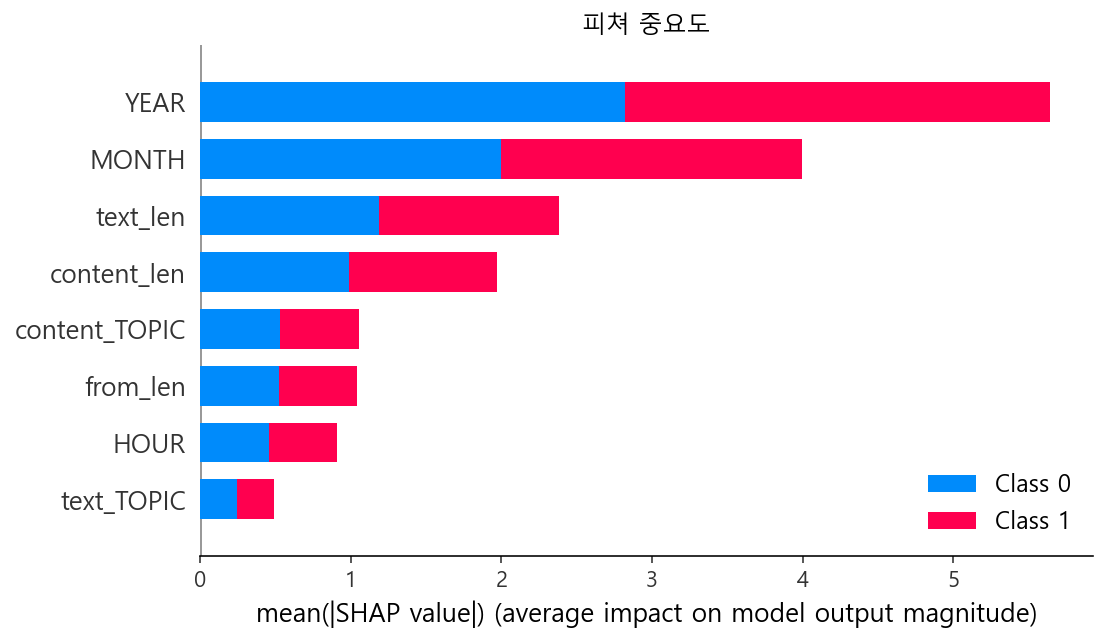

In [254]:
# Method: Using SHAP values 
# DF, based on which importance is checked
X_importance = X_train

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=0, n_jobs=-1).fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_importance)

# Plot summary_plot as barplot:
plt.title("피쳐 중요도")
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [255]:
shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
0,YEAR,2.82145
1,MONTH,1.998608
4,text_len,1.190474
5,content_len,0.985417
7,content_TOPIC,0.52902
3,from_len,0.521539
2,HOUR,0.455185
6,text_TOPIC,0.244116


In [256]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
x_train = X_train[features_selected]
x_dev =X_dev[features_selected]
train =train[features_selected]
print(x_train.shape)

(3470, 8)


In [257]:
gc.collect()   # 가비지 콜렉터를 이용해 메모리 절약

4100

#### Modeling

- LGBM 튜닝 모델 사용
- epoch 30

In [258]:
pbounds = {
    'n_estimators':(50,800),
    'learning_rate':(0.001,1.5),
    'max_depth':(2, 32),
    'num_leaves':(2, 64),
    'subsample':(0.5, 0.95),
    'colsample_bytree':(0.5, 0.95),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 50),
    'reg_alpha':(0.001, 50)
}
def lgbm_opt(n_estimators, learning_rate, max_depth, num_leaves,
             subsample, colsample_bytree, max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":int(round(n_estimators)), 
        "learning_rate":learning_rate,
        'max_depth':int(round(max_depth)),
        'num_leaves':int(round(num_leaves)),
        'subsample':max(min(subsample, 1), 0),
        'colsample_bytree':max(min(colsample_bytree, 1), 0),
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'max_bin':int(max_bin)
    }
    
#neg_mean_squared_error
    lgbm = LGBMClassifier(random_state=0, **params, n_jobs=-1)
    lgbm.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="f1", eval_set=(x_dev, y_dev), verbose=False)
    score = cross_val_score(lgbm, x_dev, y_dev, scoring="recall", cv=2, n_jobs=-1)

    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1004)
BO_lgbm.maximize(init_points=10, n_iter=20)

max_params_lgbm = BO_lgbm.max['params']
max_params_lgbm

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.525    |  0.5175   |  1.285    |  375.8    |  27.92    |  470.0    |  6.99     |  11.58    |  12.11    |  0.777    |
|  2        |  0.0      |  0.7732   |  0.1572   |  218.7    |  21.65    |  703.5    |  29.19    |  35.69    |  2.944    |  0.9092   |
|  3        |  0.0      |  0.7348   |  1.091    |  253.2    |  5.827    |  286.9    |  43.07    |  15.28    |  11.1     |  0.6029   |
|  4        |  0.475    |  0.8793   |  1.013    |  178.4    |  25.87    |  785.0    |  37.23    |  10.29    |  12.33    |  0.678    |
|  5        |  0.0      |  0.8485   |  1.24     |  286.6    |  19.7     |  364.6    |  39.47    |  41.66    |  33.68    |  0.6384   |
|  6        |  0.0      |  0.5262   |  0.5043   |  128.7    | 

{'colsample_bytree': 0.5175282373187712,
 'learning_rate': 1.2848872942722718,
 'max_bin': 375.7851508989593,
 'max_depth': 27.917836797347178,
 'n_estimators': 469.9883042448782,
 'num_leaves': 6.989950560359948,
 'reg_alpha': 11.582583288403073,
 'reg_lambda': 12.113958741688721,
 'subsample': 0.7769750057998388}

In [259]:
max_params_lgbm['n_estimators'] = int(max_params_lgbm['n_estimators'])
max_params_lgbm['max_depth'] = int(max_params_lgbm['max_depth'])
max_params_lgbm['max_bin'] = int(max_params_lgbm['max_bin'])
max_params_lgbm['num_leaves'] = int(max_params_lgbm['num_leaves'])
lgbm_clf = LGBMClassifier(random_state = 0, **max_params_lgbm)
lgbm_clf.fit(x_train,y_train)

LGBMClassifier(colsample_bytree=0.5175282373187712,
               learning_rate=1.2848872942722718, max_bin=375, max_depth=27,
               n_estimators=469, num_leaves=6, random_state=0,
               reg_alpha=11.582583288403073, reg_lambda=12.113958741688721,
               subsample=0.7769750057998388)

#### Scoring

In [260]:
# train score
y_pred = lgbm_clf.predict(train)
print("Train score")
print(classification_report(label, y_pred, target_names=['class 0', 'class 1']))

# validation score
y_pred = lgbm_clf.predict(x_dev)
print("Validation score")
print(classification_report(y_dev, y_pred, target_names=['class 0', 'class 1']))

Train score
              precision    recall  f1-score   support

     class 0       1.00      0.92      0.96      1735
     class 1       0.36      1.00      0.52        75

    accuracy                           0.92      1810
   macro avg       0.68      0.96      0.74      1810
weighted avg       0.97      0.92      0.94      1810

Validation score
              precision    recall  f1-score   support

     class 0       0.98      0.91      0.95       736
     class 1       0.29      0.65      0.40        40

    accuracy                           0.90       776
   macro avg       0.63      0.78      0.67       776
weighted avg       0.94      0.90      0.92       776



In [261]:
model = LogisticRegression(random_state=123)
model.fit(x_train, y_train)

# train score
y_pred = model.predict(train)
print("Train score")
print(classification_report(label, y_pred, target_names=['class 0', 'class 1']))

# validation score
y_pred = model.predict(x_dev)
print("Validation score")
print(classification_report(y_dev, y_pred, target_names=['class 0', 'class 1']))

Train score
              precision    recall  f1-score   support

     class 0       0.99      0.72      0.83      1735
     class 1       0.11      0.83      0.20        75

    accuracy                           0.72      1810
   macro avg       0.55      0.77      0.51      1810
weighted avg       0.95      0.72      0.81      1810

Validation score
              precision    recall  f1-score   support

     class 0       0.98      0.70      0.82       736
     class 1       0.12      0.72      0.20        40

    accuracy                           0.70       776
   macro avg       0.55      0.71      0.51       776
weighted avg       0.93      0.70      0.79       776



### 예측 결과 (성능)
-> CLASS1측면에 대한 설명   ( 읽을 것이다. )
- LGBM 모델 : 읽을 것이라고 예측한 것 중 내가 읽을 예정이었던 것은 14%를 차지한다.  (정밀도)
              TRUE값 중 POSITIVE로 맞게 예측한 비율은 53%이다. (재현율)
              읽지 않을 것(FALSE)값 중 패스할 수 있는 메일의 비율은 93%이다. 93%에 메일을 바로 보지 않고, 처리 가능. ( CLASS0의 측면 재현율) 
              
- LOGISTIC REGRESSION 모델 : 읽을 것이라고 예측한 것 중 내가 읽을 예정이었던 것은 6%를 차지한다. (정밀도)
                             TRUE값 중 POSITIVE로 맞게 예측한 비율은 85%이다.    (재현율)
                             읽지 않을 것(FALSE)값 중 패스할 수 있는 메일의 비율은 69%이다. 69%에 메일을 바로 보지 않고, 처리 가능. ( CLASS0의 측면 재현율)
                             
                         

#### 한계점
- 나의 메일 데이터 읽음, 안읽음 데이터는 imbalanced_data이기에 예측에 어려운 점이 있었다.
- 어느정도의 사용자 기반의 메일 읽기 예측을 할 수 있으나, 성능이 만족스럽지 못하다. (개선 필요)
- 메일의 피쳐 중 읽음 여부, 발신인, 메일 제목, 날짜만 사용하였으나 더 많은 피쳐를 사용할 필요가 있다.
- 머신러닝 기반의 모델만을 사용하여 딥러닝 기반 모델시 성능이 올라갈 수도 있다.
- class1의 재현율을 1에 가깝게하여 중요한 메일을 놓치지 않게끔 성능향상이 필요하다.

#### 사용자 메일 내용 워드 클라우딩
- 위와 별개 내용
- 추가적 코드 작성

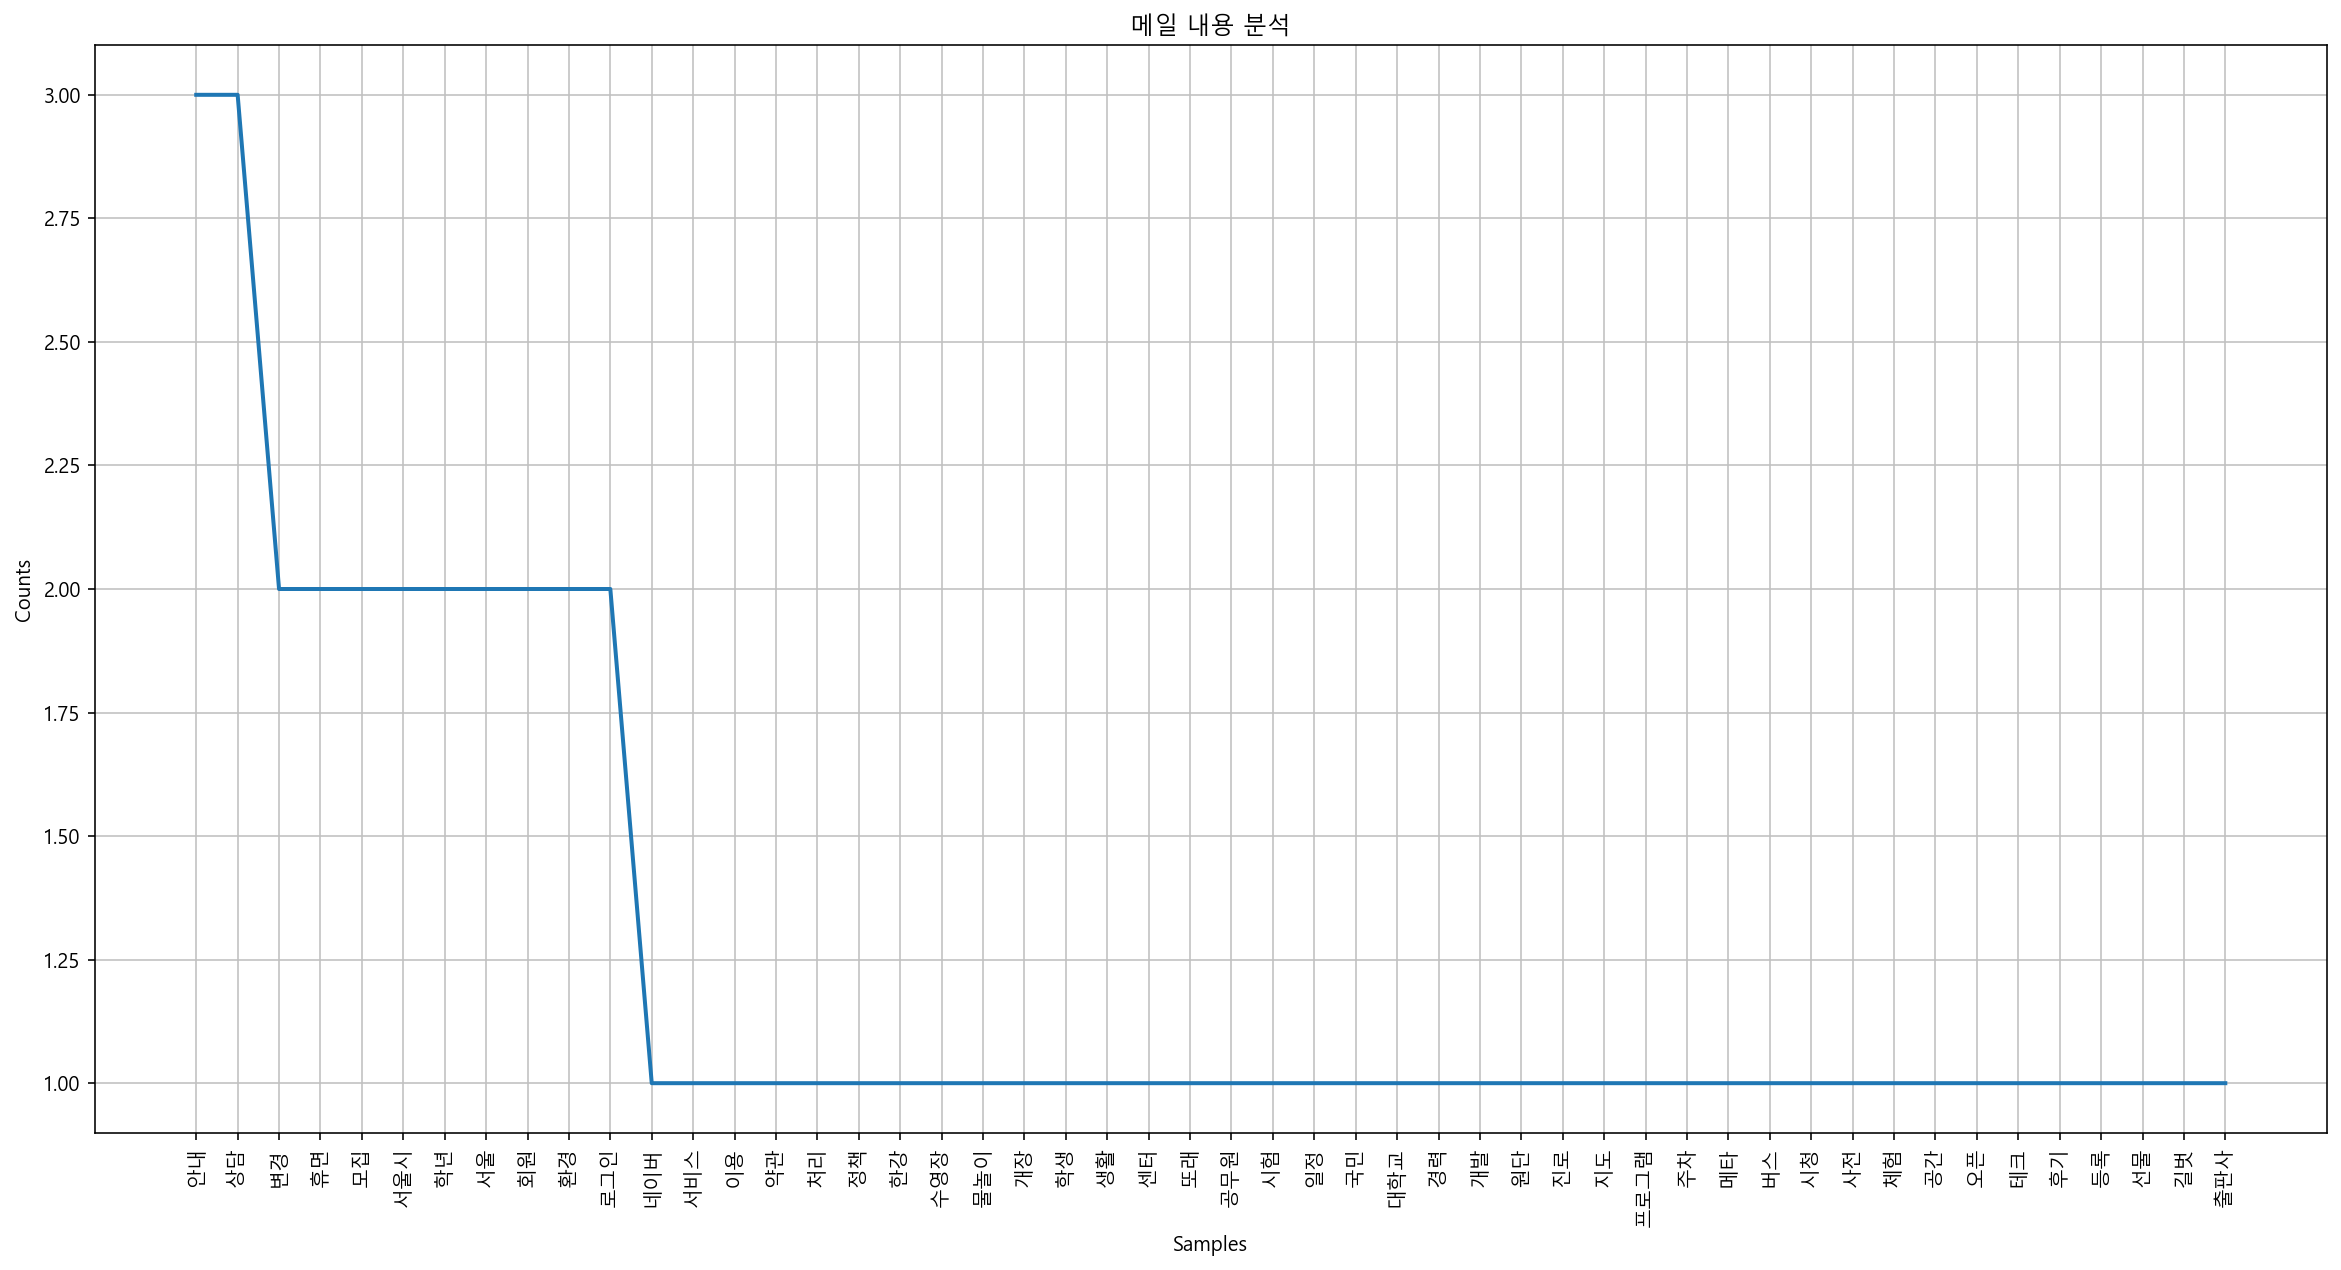

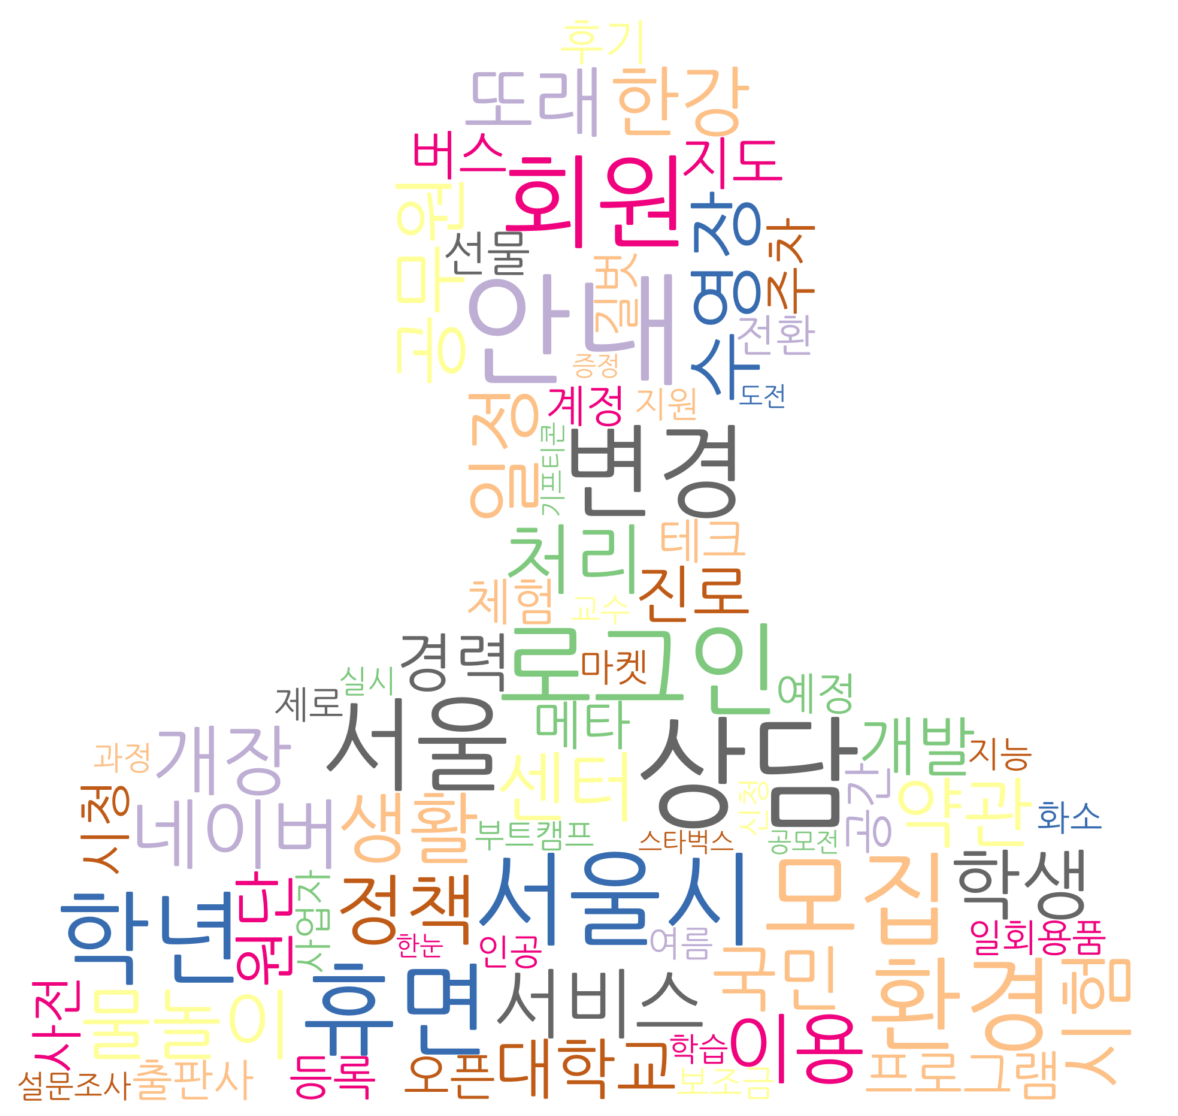

In [262]:
nouns = okt.nouns(text)
words = [n for n in nouns if len(n) > 1] 
plt.figure(figsize=(20,10))
words = nltk.Text(words)
plt.title("메일 내용 분석")
plt.xticks(rotation=50)
words.plot(50) # 50개만
plt.show()

# 단어 빈도표를 보고 일부 단어 불용어 처리
stopword = ['광고']
text = [i for i in words if i not in stopword]
text_cnt = Counter(text)

# colormap 글씨색 설정 가능, img_mask, mask 모양 설정
img_mask = np.array(Image.open("man.png"))    # 사람 이미지

wordcloud = WordCloud(font_path = 'NanumGothic.otf',   # 나눔고딕 폰트
                      background_color='white',
                      colormap = "Accent_r", 
                      mask = img_mask, 
                      random_state = 20, 
                      max_words = 500).generate_from_frequencies(text_cnt)

plt.figure(figsize = (20, 10))
plt.imshow(wordcloud, interpolation = "bilinear")        
plt.axis("off")
plt.savefig("Minseong.png")
plt.show()

#### 메일 제목을 이용한 자신의 메일함 워드 클라우딩 및 그래프 표현
- 광고, 안내, 무료, 할인, 추가 등 많은 광고 어휘 데이터가 차지하고 있어, 대부분 광고 메일임을 확인할 수 있다.
- 확인을 요하는 메일, 네이버 측에서 전달하는 메일이 많으며 웹툰 관련 메일 또한 많다.
- 전체적으로 다양한 문자의 워드 클라우딩이 형성되고 있다.